# Experiment: MLP / Circle

Compares LR baseline against 2x5x1 MLP on circle dataset.

# Setup

In [1]:
from time import time

import jax
import seaborn as sns
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import wandb

import xjax
from xjax.signals import train_epoch_completed

In [2]:
rng = jax.random.key(42)

In [3]:
wandb.init(project="mlp-circle")

wandb: Currently logged in as: andrewsomesyoung (andrewsomesyoung-projects). Use `wandb login --relogin` to force relogin


# Dataset

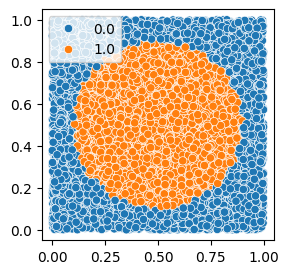

In [4]:
# Generate circle dataset
rng, dataset_rng = jax.random.split(rng)
X, y = xjax.datasets.circle(rng=dataset_rng)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax)
ax.legend(loc="upper left")

# Modeling

## Baseline

In [5]:
# Construct model
model_lr = xjax.models.sklearn.logistic_regression()

In [6]:
# Train model
model_lr = xjax.models.sklearn.train(model_lr, X=X_train, y=y_train)

In [7]:
# Test model
y_score_lr = xjax.models.sklearn.predict(model_lr, X=X_test)
auroc_lr = roc_auc_score(y_test, y_score_lr)

print(f"LR AUROC: {auroc_lr:0.4f}")

LR AUROC: 0.5119


## Candidate

In [8]:
# Hyperparameters
hiddens = [5]
batch_size = 10
epochs = 10
learning_rate = 0.01

In [9]:
wandb.config = {
    "hiddens": hiddens,
    "batch_size": batch_size,
    "epochs": epochs,
    "learning_rate": learning_rate,
}

In [10]:
# Construct model
rng, model_rng = jax.random.split(rng)
model_nn, params = xjax.models.flax.mlp(rng=model_rng, inputs=2, hiddens=hiddens)

In [11]:
start_time = time()

# Monitor model
@train_epoch_completed.connect_via(model_nn)
def monitor_model(model, epoch, loss, **_):
    elapsed = time() - start_time

    # Emit event
    wandb.log({"epoch": epoch, "loss": loss, "elapsed": elapsed})
    
    print(f"epoch={epoch}, loss={loss}")

In [12]:
# Train model
params = xjax.models.flax.train(
    model_nn,
    params=params,
    X=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=learning_rate,
)

epoch=0, loss=0.5970039963722229
epoch=1, loss=0.41874417662620544
epoch=2, loss=0.34225666522979736
epoch=3, loss=0.21582627296447754
epoch=4, loss=0.18394175171852112
epoch=5, loss=0.16728521883487701
epoch=6, loss=0.1392621248960495
epoch=7, loss=0.11403482407331467
epoch=8, loss=0.09790227562189102
epoch=9, loss=0.08721965551376343


In [13]:
# Test model
y_score_nn = xjax.models.flax.predict(model_nn, params=params, X=X_test)
auroc_nn = roc_auc_score(y_test, y_score_nn)

print(f"NN AUROC: {auroc_nn:0.4f}")

NN AUROC: 0.9943


# Analysis

In [14]:
# Track auroc
wandb.log({"auroc_lr": auroc_lr, "auroc_nn": auroc_nn})

## Predictions

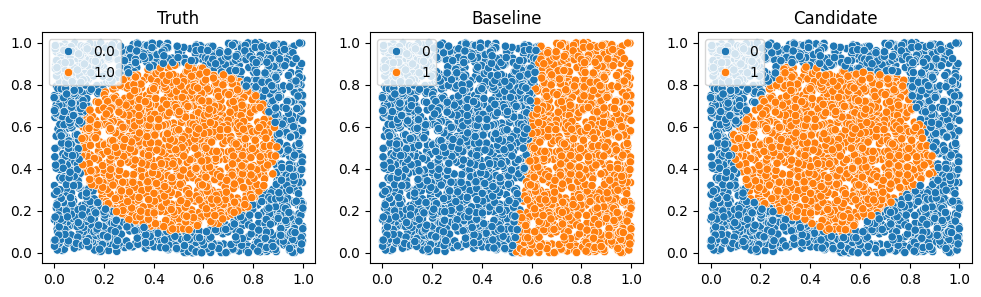

In [15]:
y_pred_lr = (y_score_lr > 0.5).astype(int)
y_pred_nn = (y_score_nn > 0.5).astype(int)

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, ax=axs[0])
axs[0].set_title("Truth")
axs[0].legend(loc="upper left")

sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_lr, ax=axs[1])
axs[1].set_title("Baseline")
axs[1].legend(loc="upper left")

sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred_nn, ax=axs[2])
axs[2].set_title("Candidate")
axs[2].legend(loc="upper left")

wandb.log({"predictions": wandb.Image(plt)})

## ROC Curves

Text(0.5, 1.0, 'Candidate ROC Curve')

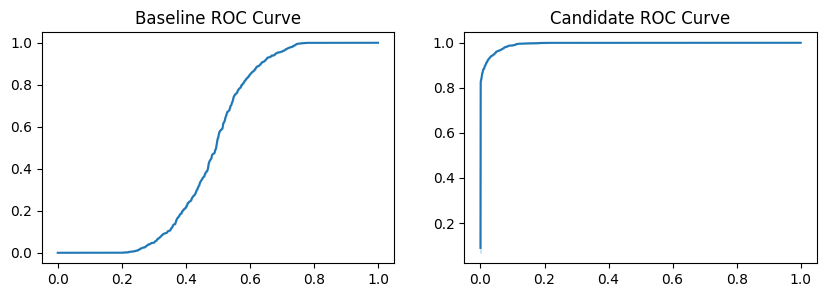

In [16]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)

fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

sns.lineplot(x=fpr_lr, y=tpr_lr, ax=axs[0])
axs[0].set_title("Baseline ROC Curve")

sns.lineplot(x=fpr_nn, y=tpr_nn, ax=axs[1])
axs[1].set_title("Candidate ROC Curve")

# Cleanup

In [17]:
wandb.finish()

auroc_lr,▁
auroc_nn,▁
elapsed,▁▂▃▃▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▃▂▂▂▁▁▁
auroc_lr,0.51186
auroc_nn,0.99427
elapsed,11.90144
epoch,9
loss,0.08722
